## Problem Statement and Background

The main domain that I will be exploring is League of Legends Esports, which is a competitive online game that is played by teams worldwide for money and prizes. Over the past decade, League of Legends has exploded in popularity, with their international tournament, Worlds, [grossing nearly 7 million concurrent viewers in 2024](https://escharts.com/news/2024-league-legends-worlds-record). League of Legends is distinct from other cognitive sports like poker or chess in that it features a “drafting phase” prior to the start of games, which involves players picking which champions they will play in the game itself. Deciding which champions to pick is an incredibly complex process, as there are over 170 to choose from, and all have complex interactions that may make them more or less favorable as the draft progresses. Gaining a better understanding of draft is relevant to not only the teams themselves, but also sports betters and analysts: [In 2023, esports betting was valued at $2.5 billion](https://www.skyquestt.com/report/esports-betting-market), and [the prize pools for Worlds 2025 alone will be $5 million](https://esportsinsider.com/2025/03/league-of-legends-lol-world-championship-2025-prize-pool).

For this reason, the main question that I am interested in is, “Can machine learning models accurately predict the outcomes of professional League of Legends games using historical game data and pre-game statistics?”.

Game outcome in this instance could be measured a number of different ways: Primarily, my starting point will be whether the game is won or lost, which seems to be the most straightforward to predict. Other potential outputs to explore could be a composite index of team or individual player performance, including objectives taken, damage dealt, gold accumulated, and kills/deaths/assists.

The main pre-game factors explored will be the teams, the draft, and the date, although these alone could be augmented into a number of other statistics, such as the team's head to head win rate or the draft's individual champion's win rates.

## Dataset

The dataset used is the Leaguepedia API, which is a third party API maintained to support Leaguepedia, a wiki for League of Legends Esports. Although it is not an official source, the API is well-maintained with very little missing attributes, especially for the professional tiers of competition where I will be pulling most of my data. For the time being, due to how comprehensive this API is on its own, I won't be augmenting with another dataset. The main challenge in working with this dataset is not the lack of data, but rather accessing it - The data is stored in a highly normalized format across nearly 100 different tables, requiring several joins to get the desired information. The full list is available [here](https://lol.fandom.com/wiki/Special:CargoTables), but the most relevant tables are [ScoreBoardGames](https://lol.fandom.com/wiki/Special:CargoTables/ScoreboardGames), which contains stats for each game, [MatchScheduleGame](https://lol.fandom.com/wiki/Special:CargoTables/MatchScheduleGame), which has less granular per-game data, [MatchSchedule](https://lol.fandom.com/wiki/Special:CargoTables/MatchSchedule), which represents a match (a set of 1-5 games), and [Tournaments](https://lol.fandom.com/wiki/Special:CargoTables/Tournaments), which represent the context in which matches are played. In addition, the SQL client available for accessing it doesn't allow subqueries, imposes a limit of 500 rows returned per request, and has a rate limit. Because of this, querying data can be a long process, and cached when possible.

## Data Joining/Cleaning

The first step in data processing was fetching historical match data. For the purpose of match prediction, since League of Legends is such a dynamic game, for the purposes of predicting future match outcomes, only the data from the last few years is relevant. In addition, to limit the influence of quality of play on prediction quality, I chose to limit the data to only professional games ("Primary" level) in the major regions, or international tournaments.

Fetching these rows is done in batches to reduce the load on the API and avoid rate limiting. The relevant data is fetched from the aforementioned four tables to provide as much pre-game context as possible. The join is done using shared columns (MatchScheduleGame and ScoreboardGame shared a GameId, MatchSchedule and MatchScheduleGame share a MatchId, and MatchSchedule and Tournament share an OverviewPage). In addition, since some games are used as placeholders and have "None" for all values, these rows are discarded. Also, games where technical issues or extraordinary circumstances forced a forfeit (FF), or replay (Chronobreak/Remake) are excluded, as the outcome of these games generally have little to do with draft or team performance. This leaves around 7600 games total. For each, the relevant pre-game statistics are pulled:

- Region: The name of the region the game was played in. Certain regions favor different champions, so this can affect draft.
- League: The name of the league the game was played in. Some regions can have more than one league, so this aids in specificity.
- IsPlayoffs: Whether the game is a playoff match. Some teams tend to perform better or worse in playoffs.
- Name: The name of the tournament the game was played in. Relevant as tournaments can influence how teams decide to draft, and some teams tend to perform better in bigger tournaments ("clutch" factor).
- Team1/Team2: The name of each team.
- Team1Blue: Derived from whether Team1 is blue side or not. Before draft, teams typically are assigned or choose a "side". Blue side chooses first in the draft, but has less picks later than red side, so both sides have strategic advantages. 
- Selection: This team has side selection going into the game. This is usually given to the team that lost the last game, and may be indicative of momentum. 
- WinTeam: Which team won
- Team1Score/Team2Score: How many games Team1/2 has won in the series. Another indicator of momentum.
- Team1Bans/Team2Bans: Which champions Team1/2 have banned going into the game before draft.
- Team1Picks/Team2Picks: Which champions Team1/2 have picked in the draft.
- Patch: Which version of the game is being played. "Balance" patches are released that tune champion power, so patch is potentially relevant for accurate predictions.
- DateTime_UTC: The time the game is played. Can account for factors like tournament and momentum.


In [70]:
from mwrogue.esports_client import EsportsClient
from cached_cargo_client import CachedCargoClient
from datetime import datetime


site = EsportsClient("lol")
cached_client = CachedCargoClient(site.cargo_client)


def get_cutoff(years_back=2):
    # Stable cutoff: start of the year X years ago
    year = datetime.utcnow().year - years_back
    return f"{year}-01-01 00:00:00"


def fetch_games(years_back=3):
    all_games = []
    cutoff_str = get_cutoff(years_back)

    offset = 0
    while True:
        response = cached_client.query(
            tables="MatchScheduleGame=MSG, ScoreboardGames=SG, Tournaments=T, MatchSchedule=MS",
            fields=(
                "T.Region, T.League, T.IsPlayoffs, T.Name, "
                "MSG.Blue, MSG.Red, MSG.Selection, SG.WinTeam, SG.Team1Score, "
                "SG.Team1, SG.Team2, SG.Team2Score, SG.Team1Bans, SG.Team2Bans, SG.Team1Picks, "
                "SG.Team2Picks, SG.Patch, SG.DateTime_UTC"
            ),
            join_on="MSG.GameId = SG.GameId, MS.MatchId = MSG.MatchId, MS.OverviewPage = T.OverviewPage",
            where=(
                "T.TournamentLevel = 'Primary' "
                "AND T.Region IN ('Americas', 'China', 'Korea', 'Europe', 'International', 'EMEA') "
                "AND SG.WinTeam IS NOT NULL "
                "AND MS.FF IS NULL "
                "AND MSG.IsRemake IS NULL "
                "AND MSG.FF IS NULL "
                "AND MSG.IsChronobreak IS NULL "
                f"AND SG.DateTime_UTC >= '{cutoff_str}'"
            ),
            limit=500,
            offset=offset,
        )
        if not response:
            break
        all_games.extend(response)
        offset += 500

    for game in all_games:
        if game["Team1"] == game["Blue"]:
            game["Team1Blue"] = "1"
        else:
            game["Team1Blue"] = "0"
        del game["Blue"]
        del game["Red"]

    return all_games


games = fetch_games()
print(len(games))
games[:5]

7638


/tmp/ipykernel_2308/535908906.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  year = datetime.utcnow().year - years_back


[{'Region': 'Americas',
  'League': 'League of Legends Championship of The Americas',
  'IsPlayoffs': '1',
  'Name': 'LTA 2025 Championship',
  'Selection': '100 Thieves',
  'WinTeam': '100 Thieves',
  'Team1Score': '1',
  'Team1': '100 Thieves',
  'Team2': 'Vivo Keyd Stars',
  'Team2Score': '2',
  'Team1Bans': 'Annie,Trundle,Akali,Poppy,Renekton',
  'Team2Bans': 'Rumble,Orianna,Ziggs,Senna,Alistar',
  'Team1Picks': 'Jax,Sejuani,Sylas,Ezreal,Karma',
  'Team2Picks': "Cho'Gath,Vi,Azir,Corki,Milio",
  'Patch': '25.18',
  'DateTime UTC': '2025-09-27 22:02:00',
  'DateTime UTC__precision': '0',
  'Team1Blue': '1'},
 {'Region': 'Americas',
  'League': 'League of Legends Championship of The Americas',
  'IsPlayoffs': '1',
  'Name': 'LTA 2025 Championship',
  'Selection': 'Vivo Keyd Stars',
  'WinTeam': 'Vivo Keyd Stars',
  'Team1Score': '0',
  'Team1': '100 Thieves',
  'Team2': 'Vivo Keyd Stars',
  'Team2Score': '1',
  'Team1Bans': 'Annie,Poppy,Azir,Renekton,Yorick',
  'Team2Bans': 'Pantheon,

Once the raw data has been fetched, we can get an idea of how clean the data is from a high level using panda's describe:

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

df = pd.DataFrame(games)

df.describe(include="all")

,Region,League,IsPlayoffs,Name,Selection,WinTeam,Team1Score,Team1,Team2,Team2Score,Team1Bans,Team2Bans,Team1Picks,Team2Picks,Patch,DateTime UTC,DateTime UTC__precision,Team1Blue
count,7638,7638,7638,7638,7286,7638,7638,7638,7638,7638,7638,7638,7638,7638,7638,7638,7638,7638
unique,6,12,2,100,91,102,4,110,111,4,7558,7527,7450,7514,62,7608,1,2
top,China,Tencent LoL Pro League,0,LPL 2022 Summer,N/A,T1,1,T1,T1,1,"None,None,None,None,None","None,None,None,None,None","Rumble,Sejuani,Yone,Xayah,Rakan","Gnar,Vi,Taliyah,Lucian,Nami",13.1,2023-03-18 09:58:00,0,1
freq,3251,3063,6330,343,346,405,3589,299,323,3252,40,40,4,4,339,2,7638,7611


Based on the output of describe, the data is already relatively clean due to our checks in the SQL query, with the only column missing values being Selection, with 7286. This is not in fact missing data, but is left intentionally blank - certain tournament formats have no concept of side selection, and sides are pre-selected for teams beforehand.

In terms of outliers, the only numeric columns which may produce outliers is the team scores, but a quick check using pandas verifies that they all fall within reasonable values if we assume that the longest series played is a best of 5:

In [ ]:
print(df["Team1Score"].value_counts())
print(df["Team2Score"].value_counts())

Team1Score
1    3589
0    2683
2    1176
3     190
Name: count, dtype: int64
Team2Score
1    3252
0    2298
2    1819
3     269
Name: count, dtype: int64


## Basic Data Characteristics

Once the raw data has been compiled and verified to be clean, basic data characteristics can be gathered. We will look at regional features first:

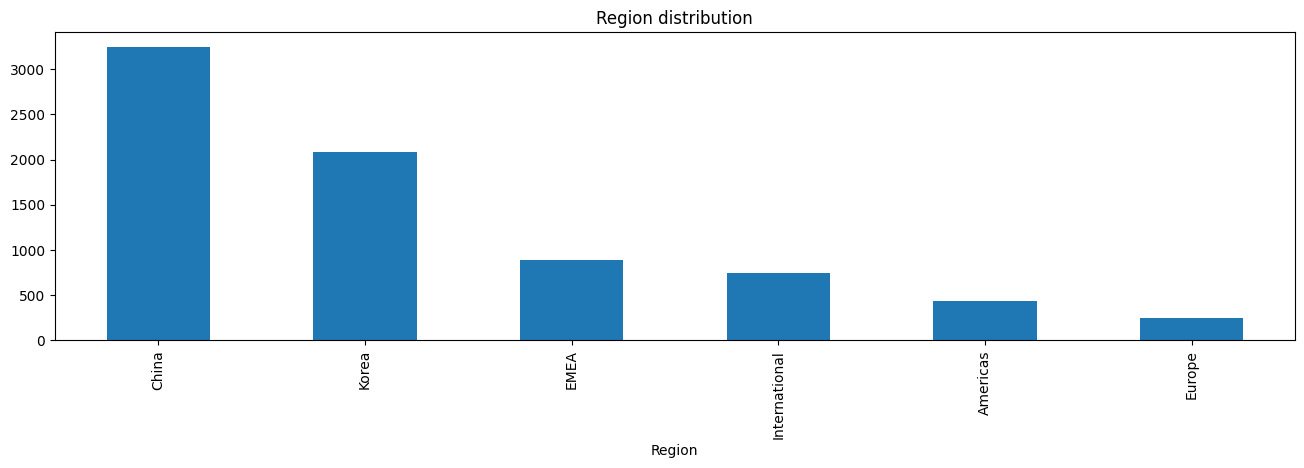

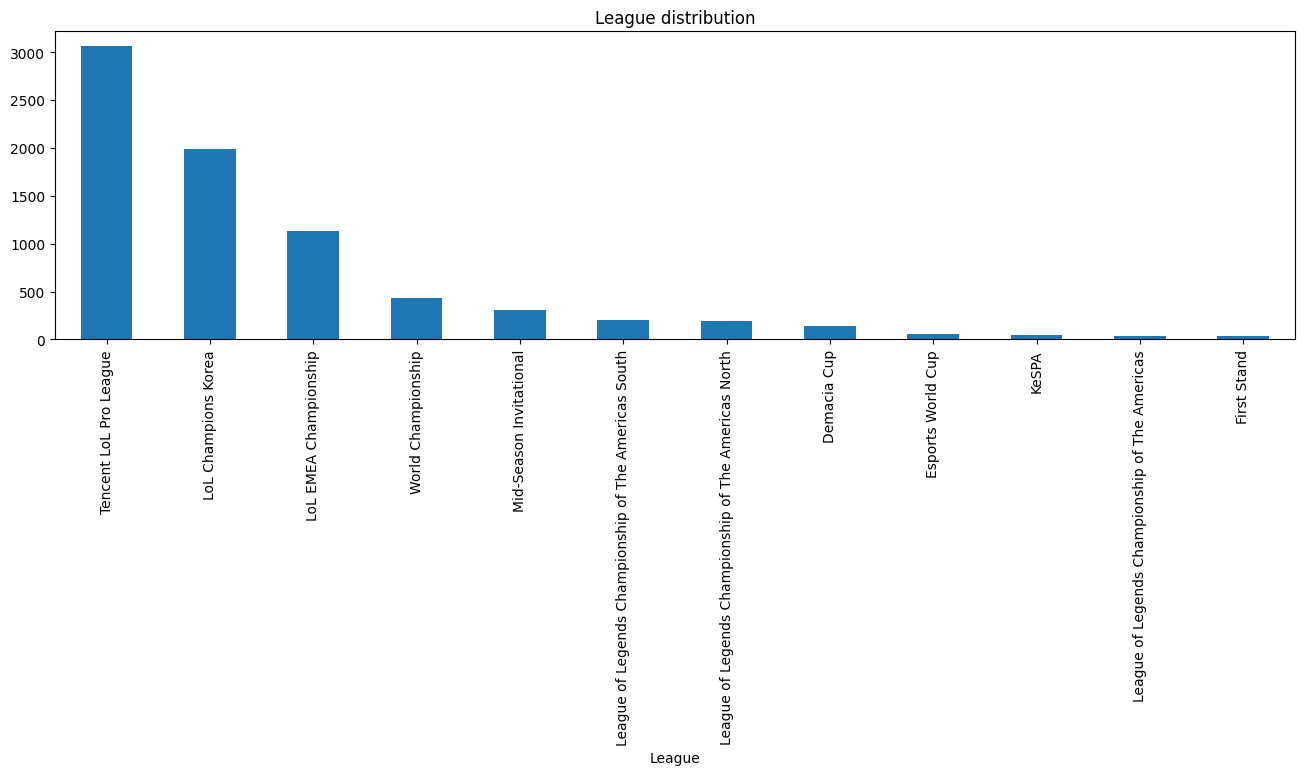

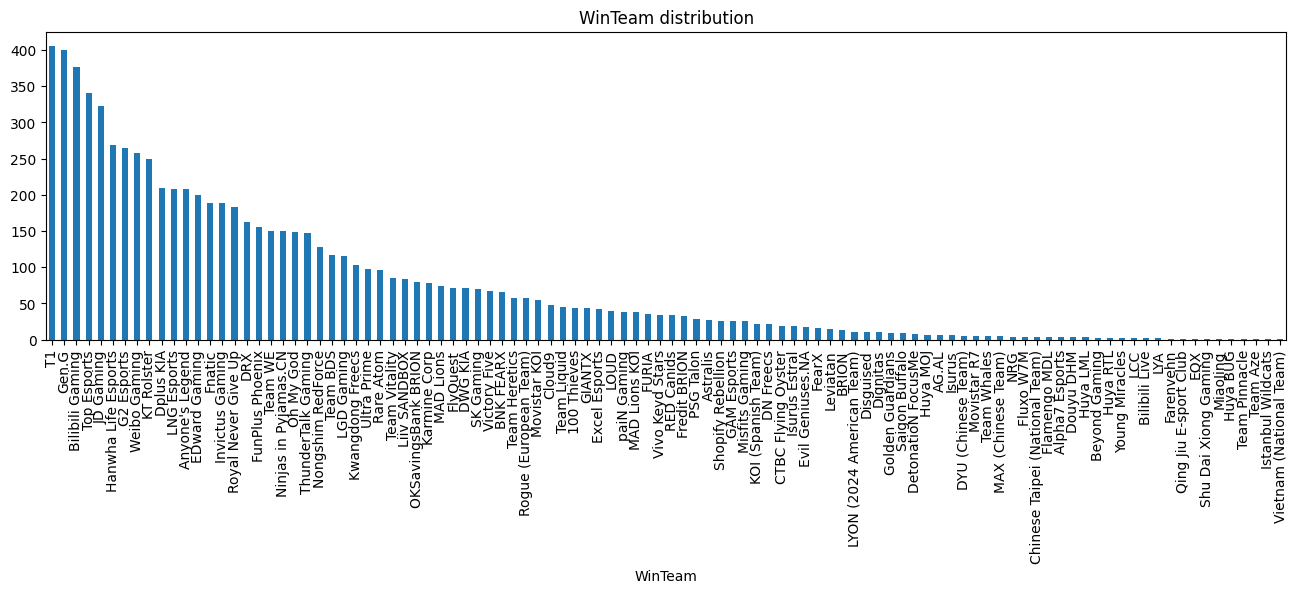

In [41]:
categorical_cols = ["Region", "League", "WinTeam"]

for col in categorical_cols:
    df[col].value_counts().plot(
        kind="bar", figsize=(16, 4), title=f"{col} distribution"
    )
    plt.show()

From these simple plots, we can get a rough idea of the data we are working with. The vast majority of the games played are in Chinese leagues (Tencent LoL Pro League) by Chinese teams. This makes sense, as the Chinese leagues are known to have the most demanding schedule, with several rounds of playoffs and regular season matches. Interestingly, however, the teams with the most wins are Korean - T1 is typically regarded as the greatest team of all time, and is highly successful, [having won two of the last three world championships](https://lol.fandom.com/wiki/World_Championship). Gen. G is typically viewed as T1's rival, and while they haven't had the same international success, [they hold the record for the most consecutive series victories](https://lol.fandom.com/wiki/Gen.G) and dominate the regular season.

Next, we will look at the types of games being played in our data:

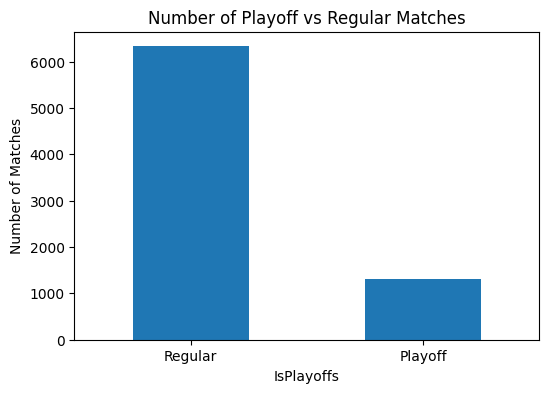

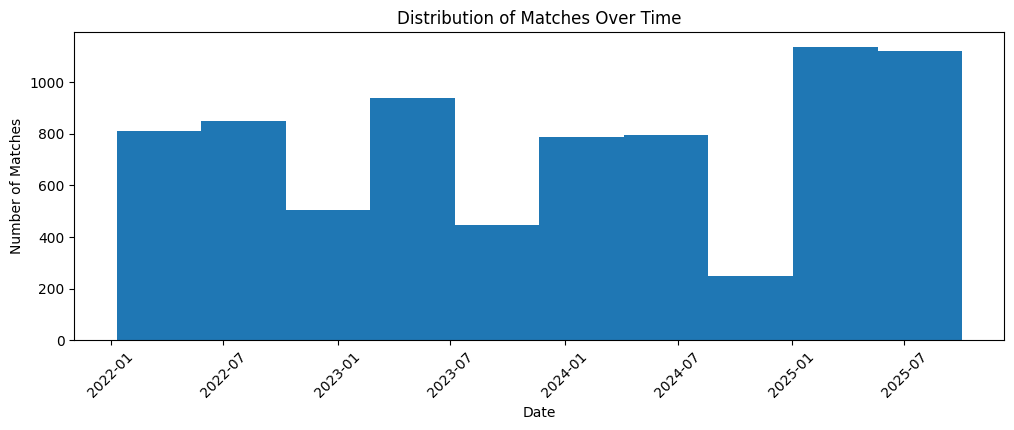

In [78]:
plt.figure(figsize=(6, 4))
df["IsPlayoffs"].value_counts().plot(kind="bar")
plt.xticks([0, 1], ["Regular", "Playoff"], rotation=0)
plt.ylabel("Number of Matches")
plt.title("Number of Playoff vs Regular Matches")
plt.show()

df["DateTime UTC"] = pd.to_datetime(df["DateTime UTC"])

plt.figure(figsize=(12, 4))
plt.hist(df["DateTime UTC"], bins=10)
plt.xlabel("Date")
plt.ylabel("Number of Matches")
plt.title("Distribution of Matches Over Time")
plt.xticks(rotation=45)
plt.show()

This reveals that the majority of the games in our dataset are regular season games, and most are being played in the 2025 season. This also makes sense, as playoffs only represent a small portion of the season, and schedule changes have resulted in more games being played recently. This should serve to our benefit, as having more recent data will allow predictions on future games to be more well-informed, as the meta is likely to have shifted less.

## Visualizations

Now that we have a basic understanding of the data, we can begin to do more deep exploration. Since the overall goal is to predict game outcomes, it would first be helpful to know which champions are competitive mainstays, and which are most successful. To do this, the top 10 most frequently picked champions are graphed vs. their win rates:

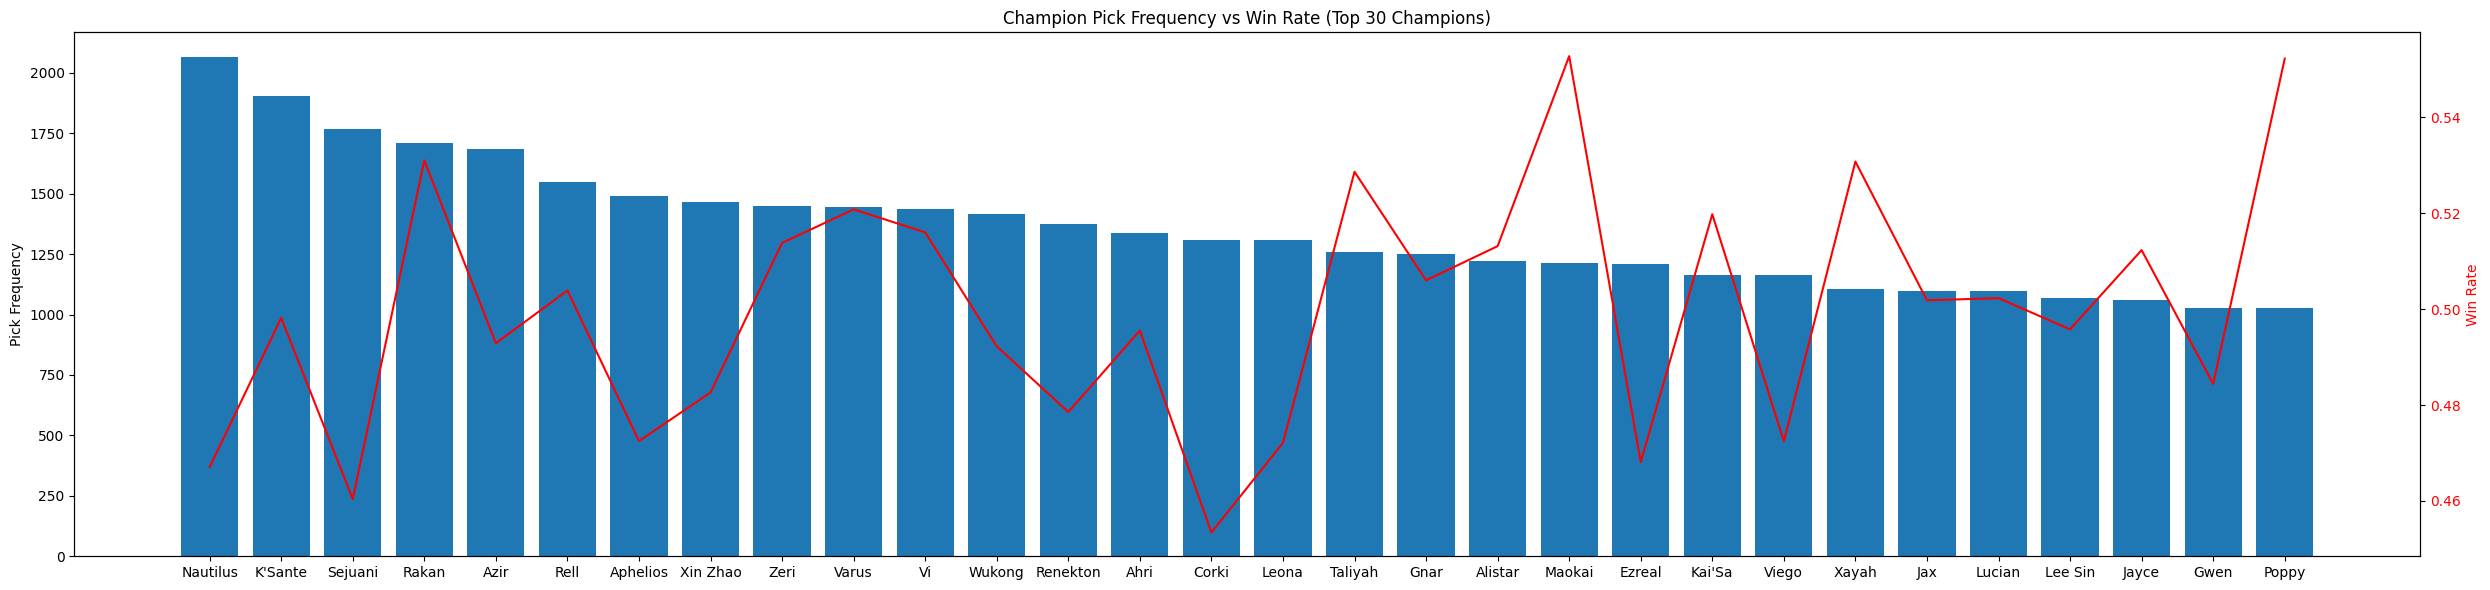

In [99]:
def explode_picks(df, team_col, picks_col, winteam_col):
    temp = df[[team_col, picks_col, winteam_col]].copy()
    temp["Win"] = (temp[team_col] == temp[winteam_col]).astype(int)
    temp = temp.drop(columns=[winteam_col])

    temp = temp.assign(Pick=temp[picks_col].str.split(",")).explode("Pick")
    temp["Pick"] = temp["Pick"].str.strip()
    temp = temp.drop(columns=[picks_col])
    return temp


team1_picks = explode_picks(df, "Team1", "Team1Picks", "WinTeam")
team2_picks = explode_picks(df, "Team2", "Team2Picks", "WinTeam")

all_picks = pd.concat([team1_picks, team2_picks])

champ_stats = (
    all_picks.groupby("Pick")
    .agg(Picks=("Pick", "count"), Wins=("Win", "sum"))
    .reset_index()
)

champ_stats["WinRate"] = champ_stats["Wins"] / champ_stats["Picks"]

top_champs = champ_stats.sort_values("Picks", ascending=False).head(30)

fig, ax1 = plt.subplots(figsize=(25, 6))

ax1.bar(top_champs["Pick"], top_champs["Picks"])
ax1.set_ylabel("Pick Frequency")
ax1.tick_params(axis="y")

ax2 = ax1.twinx()
ax2.plot(top_champs["Pick"], top_champs["WinRate"], color="red")
ax2.set_ylabel("Win Rate", color="red")
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Champion Pick Frequency vs Win Rate (Top 30 Champions)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From this, we can see that the variance in win rate among the 10 most picked champions is relatively small, with the least successful, Sejuani, only boasting a 7% lower win rate than the most successful, Rakan. This is partially due to the amount of games played smoothing out any discrepancies in player or team performance. Clearly, however, there are champions which are more winning, with Varus, Rakan, Taliyah, Maokai, and Poppy standing out as highly successful picks.

Next, I wanted to examine 

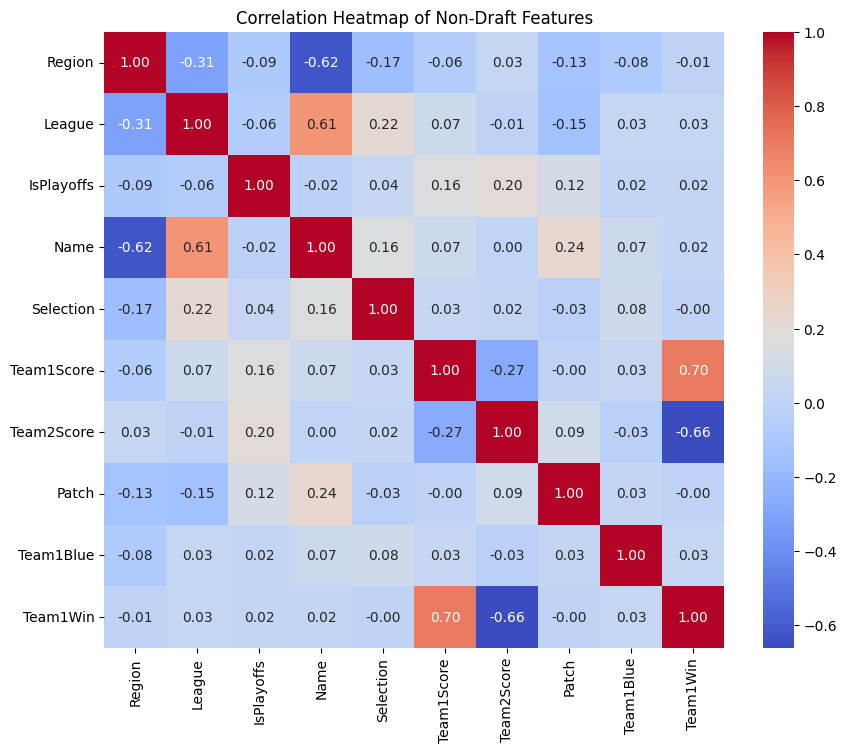

In [ ]:
non_draft_features = [
    "Region",
    "League",
    "IsPlayoffs",
    "Name",
    "Selection",
    "Team1Score",
    "Team2Score",
    "Patch",
    "Team1Blue",
]

df_corr = df[non_draft_features].copy()

categorical_cols = ["Region", "League", "Name", "Selection"]
for col in categorical_cols:
    df_corr[col] = df_corr[col].astype("category").cat.codes

df_corr[["IsPlayoffs", "Team1Score", "Team2Score", "Patch", "Team1Blue"]] = df_corr[
    ["IsPlayoffs", "Team1Score", "Team2Score", "Patch", "Team1Blue"]
].apply(pd.to_numeric, errors="coerce")

df_corr["Team1Win"] = (df["WinTeam"] == df["Team1"]).astype(int)
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix)
plt.title("Correlation Heatmap of Non-Draft Features")
plt.show()

In [ ]:
# def encode_and_normalize(games):
#     df = pd.DataFrame(games)
#     df["blue_win"] = (df["WinTeam"] == df["Blue"]).astype(int)

#     team_encoder = LabelEncoder()
#     df["blue_team_id"] = team_encoder.fit_transform(df["Blue"])
#     df["red_team_id"] = team_encoder.fit_transform(df["Red"])

#     patch_encoder = LabelEncoder()
#     df["patch_id"] = patch_encoder.fit_transform(df["Patch"])

#     df["selection_blue"] = (df["Selection"] == df["Blue"]).astype(int)

#     df["date"] = pd.to_datetime(df["DateTime UTC"])
#     df["year"] = df["date"].dt.year
#     df["month"] = df["date"].dt.month

#     df["blue_picks"] = df["Team1Picks"].str.split(",")
#     df["red_picks"] = df["Team2Picks"].str.split(",")
#     df["blue_bans"] = df["Team1Bans"].str.split(",")
#     df["red_bans"] = df["Team2Bans"].str.split(",")

#     all_champs = sorted(
#         set(
#             sum(df["blue_picks"], [])
#             + sum(df["red_picks"], [])
#             + sum(df["blue_bans"], [])
#             + sum(df["red_bans"], [])
#         )
#     )

#     champ_features = {}
#     for champ in all_champs:
#         champ_features[f"pick_blue_{champ}"] = df["blue_picks"].apply(
#             lambda picks: int(champ in picks)
#         )
#         champ_features[f"pick_red_{champ}"] = df["red_picks"].apply(
#             lambda picks: int(champ in picks)
#         )
#         champ_features[f"ban_blue_{champ}"] = df["blue_bans"].apply(
#             lambda bans: int(champ in bans)
#         )
#         champ_features[f"ban_red_{champ}"] = df["red_bans"].apply(
#             lambda bans: int(champ in bans)
#         )

#     df = pd.concat([df, pd.DataFrame(champ_features, index=df.index)], axis=1)
#     # Drop original text columns that are now encoded
#     drop_cols = [
#         "Blue",
#         "Red",
#         "WinTeam",
#         "Team1Picks",
#         "Team2Picks",
#         "Team1Bans",
#         "Team2Bans",
#         "Patch",
#         "Selection",
#         "DateTime UTC",
#         "DateTime UTC__precision",
#         "blue_picks",
#         "red_picks",
#         "blue_bans",
#         "red_bans",
#         "date",
#     ]
#     df = df.drop(columns=drop_cols)

#     return df


# df = encode_and_normalize(games)
# print(df[''])